### Deploy and Interact with Consent based Smart Contract
The aim of this notebook is to compile, deploy and interact with consent based smart contract

# Compile contract from file

In [106]:
# Import libraries
import json
import web3
from datetime import datetime
from web3 import Web3

# import py_solc_x as px
import solcx
from web3.contract import Contract
import os
import pandas as pd

# from brownie import  web3

# import icd10

In [107]:
# Read in LUCE contract code
# solcx.install_solc('0.8.0')
print(os.getcwd())
consent_fp = r"data\UnifiedConsentModel.sol"
# consent_fp_relative = r"jupyter\\data\\UnifiedConsentModel.sol"
with open(consent_fp) as file:
    contract_source_code = file.read()

# Compile & Store Compiled source code
# print(contract_source_code)
solcx_version = "0.8.17"
# solcx_version = '0.5.16'
# solcx.install_solc(solcx_version)
# compiled_sol = solcx.compile_source(source=contract_source_code,
#   solc_binary="/snap/bin/solc")
compiled_sol = solcx.compile_source(
    source=contract_source_code,
    # solc_binary='/usr/bin/solc',
    # optimize_runs=200,
    output_values=["abi", "bin", "bin-runtime"],
    optimize=True,
    solc_version=solcx_version,
)

# compiled_sol = solcx.compile_files(source_files=consent_fp,
#                                     # solc_binary='/usr/bin/solc',
#                                     # optimize_runs=200,
#                                     output_values=["abi", "bin",'bin-runtime'],
#                                     # optimize=True,
#                                     solc_version = solcx_version
#                                     )

print(compiled_sol.keys())
# Extract full interface as dict from compiled contract
contract_interface = compiled_sol["<stdin>:ConsentCode"]
# contract_interface = compiled_sol['data/ConsentContractDate.sol:ConsentCode']
print(contract_interface.keys())
# contract_interface
# Extract abi and bytecode
abi = contract_interface["abi"]
bytecode = contract_interface["bin"]
### Deploy
startTime = datetime.now()
# Use Ganache for web3 instance
w3 = Web3(Web3.HTTPProvider("HTTP://127.0.0.1:8545"))

# compiled_contract = web3.eth.compile_contract(contract_source)
# abi = compiled_contract["abi"]
# bytecode = compiled_contract["bytecode"]
# contract_address = web3.eth.contract(abi=abi, bytecode=bytecode).deploy()

# assert True is w3.isConnected()
# Use local Ganache GUI on macOS
# w3 = Web3(Web3.HTTPProvider("HTTP://192.168.72.1:7545"))
# Set pre-funded ganache account #0 as sender
w3.eth.defaultAccount = w3.eth.accounts[0]
w3.eth.accounts
# The default `eth.defaultAccount` address is used as the default "from" property for request_1_address dictionaries if no other explicit "from" property is specified.
# Create contract blueprint
contract = w3.eth.contract(abi=abi, bytecode=bytecode)
# Submit the request_1_address that deploys the contract
provider_address = w3.eth.accounts[0]
provider_address_sum = Web3.to_checksum_address(provider_address)

request_1_address = w3.eth.accounts[1]
request_1_address_sum = Web3.to_checksum_address(request_1_address)

request_2_address = w3.eth.accounts[2]
request_2_address_sum = Web3.to_checksum_address(request_1_address)

tx_hash = contract.constructor().transact({"from": provider_address, "gas": int(1e7)})


tx_hash
### Obtain Transcation Receipt
# Wait for the request_1_address to be mined, and get the request_1_address receipt
# tx_receipt = w3.eth.waitForrequest_1_addressReceipt(tx_hash)

tx_receipt = w3.eth.wait_for_transaction_receipt(tx_hash, timeout=120, poll_latency=0.1)

# We obtain the block number under which it is deployed
# global contract_block
contract_block = w3.eth.block_number
print("The contract is deployed with block number", contract_block, ".")
# With obtain the final address of the contract

# global contract_address
contract_address = tx_receipt.contractAddress

print("The contract has the address", contract_address)
gas_limit = int(1e7)
provider_dict = {
    "from": provider_address,
    "to": contract_address,
    "value": 0,
    "gas": gas_limit,
    # 'gasPrice': w3.eth.gas_price*0.1,
    # 'nonce': 33 ,
}

requester_1_dict = {
    "from": request_1_address,
    "to": contract_address,
    "value": 0,
    "gas": gas_limit,
    # 'gasPrice': w3.eth.gas_price*0.1,
    # 'nonce': 33 ,
}

requester_2_dict = {
    "from": request_2_address,
    "to": contract_address,
    "value": 0,
    "gas": gas_limit,
    # 'gasPrice': w3.eth.gas_price*0.1,
    # 'nonce': 33 ,
}
### Interact with contract
# Create python instance of deployed contract
# caddress = '0x3FEAfC9084e95BC5B07FBbBd197Af22422A46019'
contract = w3.eth.contract(
    address=contract_address,
    abi=abi,
    # bytecode=bytecode,
)
# Extract default accounts created by ganache
accounts = w3.eth.accounts
accounts

d:\WorkSpace\Maastricht\LUCE\DecentralizedHealthcareBackend\jupyter
dict_keys(['<stdin>:ConsentCode'])
dict_keys(['abi', 'bin', 'bin-runtime'])
The contract is deployed with block number 3109 .
The contract has the address 0x9882c00189d1987E80DEbA193E1cf41030b3Cf25


['0x84dF8A457982333C0893b968872F57b963243307',
 '0x159f33a7b5a9fB939b8AC6f8CE2E54e7eaE13bE0',
 '0x68C0eC5c56f0EDe43affA748e5D4aFd87f31513d']

# Test cases

## Disease Name

In [108]:
import re

pattern = r"^[A-Z][0-9]{2}$"
pattern_compiled = re.compile(pattern)

def diseaseCode2IntHierarchy(code: str) -> (int,int):
    #  the code is a string like A00,B11, etc.
    #  return the int code for chapter, group as a tuple
    if not pattern_compiled.match(code):
        print(f"The string {code} not matches the pattern")
        return 0
    chapter_str = code[0]
    # if chapter_str == "*":
    #     return 2**8-1,2**128-1
    chapter_int = int(ord(code[0]) - ord("A")) + 1
    group_str = code[1:3]
    if group_str == "**":
        return chapter_int,2**128-1
    group_int = int(code[1:3])
    # represent group_int as 128 bits
    return chapter_int, group_int
    

        

def diseaseCode2Int(code: str) -> int:
    # r = fx.UInt16(0)
    # print(bin(r))
    # since A00.0 is a correct code, so plus 1 for each level
    if not pattern_compiled.match(code):
        print(f"The string {code} not matches the pattern")
        return 0
    chapter_str = code[0]
    group_str = code[1:3]
    category_str = code[-1]
    result = 0
    if chapter_str == "*":
        return 0
        # chapter_int = 0
    else:
        chapter_int = int(ord(code[0]) - ord("A")) + 1
        b_chapter = (chapter_int) << 11

    if group_str == "**" or group_str == "*":
        return b_chapter
    else:
        group_int = int(code[1:3]) + 1
        b_group = (group_int) << 4

    # if category_str == "*":
    #     return b_chapter + b_group
    # else:
    #     category_int = int(code[-1]) + 1
    # return b_chapter + b_group + category_int
    return b_chapter + b_group

def int2DiseaseCode(code: int) -> str:
    if code == 0:
        return "*00.0"
    chapter_int = code >> 11
    chapter_str = chr(chapter_int + ord("A") - 1)
    group_int = (code >> 4) & 0b1111111
    group_str = str(group_int - 1).zfill(2)
    category_int = code & 0b1111
    category_str = str(category_int - 1)
    return f"{chapter_str}{group_str}.{category_str}"

## BooleanItems

In [109]:
# print(contract.address)
# print(contract.functions)


# print(contract.checkAccess(requester_1_dict))


class BooleanItems:
    ClinicalProfessionals = False
    AcademicProfessionals = False
    ReferenceOrControlMaterial = False
    MethodsDevelopment = False
    PopulationsResearch = False
    AncestryResearch = False
    FundamentalBioResearch = False
    DrugDevelopmentResearch = False
    AgeCategoriesResearch = False
    GenderCategoriesResearch = False
    ProfitPurpose = False
    ProfitMakingProfessionals = False
    FormalApprovalRequired = False

    def to_list(self):
        return [
            self.ClinicalProfessionals,
            self.AcademicProfessionals,
            self.ReferenceOrControlMaterial,
            self.MethodsDevelopment,
            self.PopulationsResearch,
            self.AncestryResearch,
            self.FundamentalBioResearch,
            self.DrugDevelopmentResearch,
            self.AgeCategoriesResearch,
            self.GenderCategoriesResearch,
            self.ProfitPurpose,
            self.ProfitMakingProfessionals,
            self.FormalApprovalRequired,
        ]

    def to_int(self):
        result = 0
        bool_list = self.to_list()
        for i in range(len(bool_list)):
            result += bool_list[i] << i
        return result

    def decode_from_int(self, int_value):
        bool_list = []
        for i in range(13):
            bool_list.append((int_value >> i) & 1)
        self.ClinicalProfessionals = bool_list[0]
        self.AcademicProfessionals = bool_list[1]

        self.ReferenceOrControlMaterial = bool_list[2]
        self.MethodsDevelopment = bool_list[3]
        self.PopulationsResearch = bool_list[4]
        self.AncestryResearch = bool_list[5]
        self.FundamentalBioResearch = bool_list[6]
        self.DrugDevelopmentResearch = bool_list[7]
        self.AgeCategoriesResearch = bool_list[8]
        self.GenderCategoriesResearch = bool_list[9]
        self.ProfitPurpose = bool_list[10]
        self.ProfitMakingProfessionals = bool_list[11]
        self.FormalApprovalRequired = bool_list[12]
        return self

    def show_true_items(self):
        result = []
        for k, v in self.__dict__.items():
            if v:
                result.append(k)
        return result


role_provider = 1
role_requester = 2


## Person

In [110]:
class Person:
    address = 0
    name = ""
    description = ""

    boolItems = BooleanItems()

    disease_items = []
    country_names = []
    group_names = 0
    start_year = 0
    start_month = 0
    start_day = 0
    months = 0

    contract = None
    person_dict = None
    role = 0

    estimate_gas = False

    country_name_code_dict = json.load(open("data/countries_enrich.json", "r"))
    group_index_dict = json.load(open("data/group_index.json", "r"))
    # allowed_group_names = {"EUROPEAN_UNION"}
    group_order_index_dict = {
        name: index for index, name in enumerate(group_index_dict.keys())
    }
    country_code_name_dict = {v["index"]: k for k, v in country_name_code_dict.items()}

    def __init__(self, name, description, contract, person_dict):
        self.name = name
        self.address = person_dict["from"]
        self.description = description
        self.contract = contract
        self.person_dict = person_dict

        # for k, v in self.country_name_code_dict.items():
        #     v["groups"] = [g for g in v["groups"] if g in self.allowed_group_names]
        # #  generate index of allowed_group_names
        # self.group_index_dict = {
        #     g: 2**i for i, g in enumerate(self.allowed_group_names)
        # }

    def upload_simple_items(self):
        upload_func = self.contract.functions.UploadSimpleItems(
            self.role, self.address, self.boolItems.to_int()
        )
        return self.forward(upload_func)

    def display_simple_items(self):
        func = self.contract.functions.DisplaySimpleItems(self.role, self.address)
        if self.estimate_gas:
            gas = func.estimate_gas()
            print(f"Estimated gas cost for displaySimpleItems: {gas}")
        result = func.call()
        boolItems = BooleanItems()
        boolItems.decode_from_int(result)
        # print(f"displaySimpleItems is {boolItems.show_true_items()}")

    def upload_area_code_baseline(self):
        country_codes = [
            self.country_name_code_dict[c]["index"] for c in self.country_names
        ]
        # print("UploadCountryItems", country_codes)
        group_codes = [self.group_order_index_dict[g] for g in self.group_names]
        func = self.contract.functions.UploadAreaCodeBaseline(
            self.role,
            self.address,
            group_codes,
            country_codes,
        )
        # print("UploadAreaCode role", self.role)
        return self.forward(func)

    def update_area_group_code(self):
        country_group_dict = {}
        for c in self.country_names:
            if c not in self.country_name_code_dict:
                print(f"{c} not in country_dict")
                return
            country_dict = self.country_name_code_dict[c]
            groups = country_dict["groups"]
            if len(groups) == 0:
                continue
            for g in groups:
                g_index = self.group_index_dict[g]
                if g_index not in country_group_dict:
                    country_group_dict[g_index] = 0
                country_group_dict[g_index] |= country_dict["index"]
        country_group_data = list(country_group_dict.values())
        country_group_index = list(country_group_dict.keys())
        # print("country_group_dict", country_group_dict)
        func = self.contract.functions.UpdateCountryGroupCodeData(
            country_group_data, country_group_index
        )
        # func.transact(self.person_dict)
        return self.forward(func)

    def update_area_group_code_baseline(self, part_number=20):
        def split(a, n):
            k, m = divmod(len(a), n)
            return tuple(
                a[i * k + min(i, m) : (i + 1) * k + min(i + 1, m)] for i in range(n)
            )

        country_group_dict = {}
        for c in self.country_names:
            if c not in self.country_name_code_dict:
                print(f"{c} not in country_dict")
                return
            country_dict = self.country_name_code_dict[c]

            country_group_dict[country_dict["index"]] = [
                self.group_order_index_dict[g] for g in country_dict["groups"]
            ]

        country_code_list = list(country_group_dict.keys())
        country_group_index_list = list(country_group_dict.values())
        country_number = len(country_code_list)
        # print("country_group_dict", country_group_dict)
        country_code_list_part = split(country_code_list, part_number)
        country_group_index_list_part = split(country_group_index_list, part_number)
        gas = 0
        for i in range(part_number):
            func = self.contract.functions.UpdateCountryCodeBaseline(
                country_code_list_part[i], country_group_index_list_part[i]
            )
            func_gas = func.estimate_gas()
            gas += func_gas
        return gas

    def upload_area_code_simple(self):
        country_codes = [
            self.country_name_code_dict[c]["index"] for c in self.country_names
        ]
        # print("UploadCountryItems", country_codes)
        group_codes = [self.group_index_dict[g] for g in self.group_names]
        country_group_data = []
        country_group_index = []

        group_code = sum(group_codes)
        country_code = sum(country_codes)

        # print("country_group_data length", len(country_group_data))

        func = self.contract.functions.UploadAreaSimple(
            self.role, self.address, group_code, country_code
        )
        # print("UploadAreaCode role", self.role)

        return self.forward(func)

    def upload_area_code_only(self):
        country_codes = [
            self.country_name_code_dict[c]["index"] for c in self.country_names
        ]
        # print("UploadCountryItems", country_codes)
        group_codes = [self.group_index_dict[g] for g in self.group_names]
        country_group_code = 0
        for c in self.country_names:
            if c not in self.country_name_code_dict:
                print(f"{c} not in country_dict")
                return
            groups = self.country_name_code_dict[c]["groups"]
            if len(groups) == 0:
                continue
            for g in groups:
                country_group_code += self.group_index_dict[g]
        group_code = sum(group_codes)
        country_code = sum(country_codes)
        func = self.contract.functions.UploadAreaOnly(
            self.role,
            self.address,
            group_code,
            country_code,
            country_group_code,
        )
        # print("UploadAreaCode role", self.role)
        return self.forward(func)

    def display_area_codes(self):
        (
            Group_Code,
            Country_Codes,
            Country_Group_Codes,
        ) = self.contract.functions.DisplayAreaCode(self.role, self.address).call()
        # groupp_code is a int of the sum of the value of group_index_dict, decode it according to the group_index_dict
        group_names = []
        for k, v in self.group_index_dict.items():
            if v & Group_Code:
                group_names.append(k)
        # print("displayAreaCodes", Country_Codes)
        # print("Country_Group_Codes", Country_Group_Codes)
        country_names = [self.country_code_name_dict[c] for c in Country_Codes]
        result = {"group_names": group_names, "country_codes": country_names}
        print(f"displayAreaCodes is {result}")

    def upload_disease_items(self):
        disease_codes = [diseaseCode2Int(d) for d in self.disease_items]
        func = self.contract.functions.UploadDiseaseCode(
            self.role, self.address, disease_codes
        )
        return self.forward(func)

    def upload_disease_items_hierarchy(self):
        disease_codes = [diseaseCode2IntHierarchy(d) for d in self.disease_items]
        disease_dict = {}

        for d in disease_codes:
            if d[0] not in disease_dict:
                disease_dict[d[0]] = 0
            disease_dict[d[0]] |= d[1]
        disease_group_codes, disease_chapter_codes = (
            list(disease_dict.keys()),
            list(disease_dict.values()),
        )
        func = self.contract.functions.UploadDiseaseCodeHierarchy(
            self.role, self.address, disease_group_codes, disease_chapter_codes
        )
        return self.forward(func)

    def display_disease_items(self):
        disease_codes = self.contract.functions.DisplayDiseaseCode(
            self.role, self.address
        ).call()
        disease_names = []
        for d in disease_codes:
            disease_names.append(int2DiseaseCode(d))
        result = {"disease_names": disease_names}
        print(f"displayDiseaseItems is {result}")

    def upload_date(self):
        func = self.contract.functions.UploadDate(
            self.role,
            self.address,
            self.Start_Year,
            self.Start_Month,
            self.Start_Day,
            self.Months,
        )
        return self.forward(func)

    def display_date(self):
        (
            Start_Year,
            Start_Month,
            Start_Day,
            Months,
        ) = self.contract.functions.DisplayDate(self.role, self.address).call()
        print(
            f"displayDate: Start_Year is {Start_Year}, Start_Month is {Start_Month}, Start_Day is {Start_Day}, Months {Months}"
        )
        return Start_Year, Start_Month, Start_Day, Months

    def forward(self, func, call=False):
        if self.estimate_gas:
            gas = func.estimate_gas()
            return gas
        else:
            if call:
                return func.call()
            else:
                recipt = func.transact(self.person_dict)
                return recipt

    def __str__(self):
        return f"Person: {self.name},  {self.description}, {self.role}"


class Provider(Person):
    # def __init__(self):
    #     # super().__init__(*args,**kwargs)
    #     self.role = 1
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.role = role_provider

## Requester Class

In [111]:
class Requester(Person):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.role = role_requester

    # def __init__(self):
    #     self.role = 2

    def _check_role(self, provider: Provider):
        if provider.role != role_provider:
            raise Exception("requestAccess: provider is not a Provider")
        if self.role != role_requester:
            raise Exception("requestAccess: requester is not a Requester")

    def request_access(self, provider: Provider):
        if provider.role != role_provider:
            print("requestAccess: provider is not a Provider")
            return
        if self.role != role_requester:
            print("requestAccess: requester is not a Requester")
            return
        func = self.contract.functions.AccessData(provider.address, self.address)
        return self.forward(func, True)

    def access_disease(self, provider: Provider):
        if provider.role != role_provider:
            print("requestAccess: provider is not a Provider")
            return
        if self.role != role_requester:
            print("requestAccess: requester is not a Requester")
            return
        func = self.contract.functions.CheckDisease(provider.address, self.address)
        return self.forward(func, True)

    def access_disease_hierarchy(self, provider: Provider):
        if provider.role != role_provider:
            print("requestAccess: provider is not a Provider")
            return
        if self.role != role_requester:
            print("requestAccess: requester is not a Requester")
            return
        func = self.contract.functions.CheckDiseaseHierarchy(
            provider.address, self.address
        )
        return self.forward(func, True)

    def access_area_baseline(self, provider: Provider):
        if provider.role != role_provider:
            print("requestAccess: provider is not a Provider")
            return
        if self.role != role_requester:
            print("requestAccess: requester is not a Requester")
            return
        func = self.contract.functions.CheckAreaBaseline(provider.address, self.address)
        return self.forward(func, True)

    def access_area_simple(self, provider: Provider):
        self._check_role(provider)
        func = self.contract.functions.checkAreaSimple(provider.address, self.address)
        return self.forward(func, True)

## Disease

In [112]:
provider1 = Provider(
    name="Provider_disease",
    description="Provider1",
    contract=contract,
    person_dict=provider_dict,
)
requester1 = Requester(
    name="Requester_disease",
    description="Requester1",
    contract=contract,
    person_dict=requester_1_dict,
)


def generate_disease_items(chapters=["A"], numbers=[10]):
    result = []
    chapter = "A"
    for i in range(len(chapters)):
        chapter = chapters[i]
        number = numbers[i]
        if number > 99:
            raise ValueError("numbers should be less than 100")

        for i in range(number):
            result.append(chapter + str(i).zfill(2))

    return result


intevals = [1, 10, 20, 30, 40, 50, 60, 70, 80, 90]
# intevals = [1]
provider1.estimate_gas = True
requester1.estimate_gas = True

disease_data = []
for interval in intevals:
    disease_items = generate_disease_items(numbers=[interval])
    provider1.disease_items = disease_items
    requester1.disease_items = disease_items

    gas_provider = provider1.upload_disease_items()
    gas_requester = requester1.upload_disease_items()
    gas_access = requester1.request_access(provider1)

    gas_provider_h = provider1.upload_disease_items_hierarchy()
    gas_requester_h = requester1.upload_disease_items_hierarchy()
    # gas_access_disease = requester1.access_disease(provider1)
    gas_access_disease_hierarchy = requester1.access_disease_hierarchy(provider1)
    disease_data.append(
        {
            "interval": interval,
            "gas_provider": gas_provider,
            "gas_requester": gas_requester,
            "gas_access": gas_access,
            "category": "base",
        }
    )
    disease_data.append(
        {
            "interval": interval,
            "gas_provider": gas_provider_h,
            "gas_requester": gas_requester_h,
            "gas_access": gas_access_disease_hierarchy,
            "category": "hierarchy",
        }
    )


disease_data_frame = pd.DataFrame(disease_data)

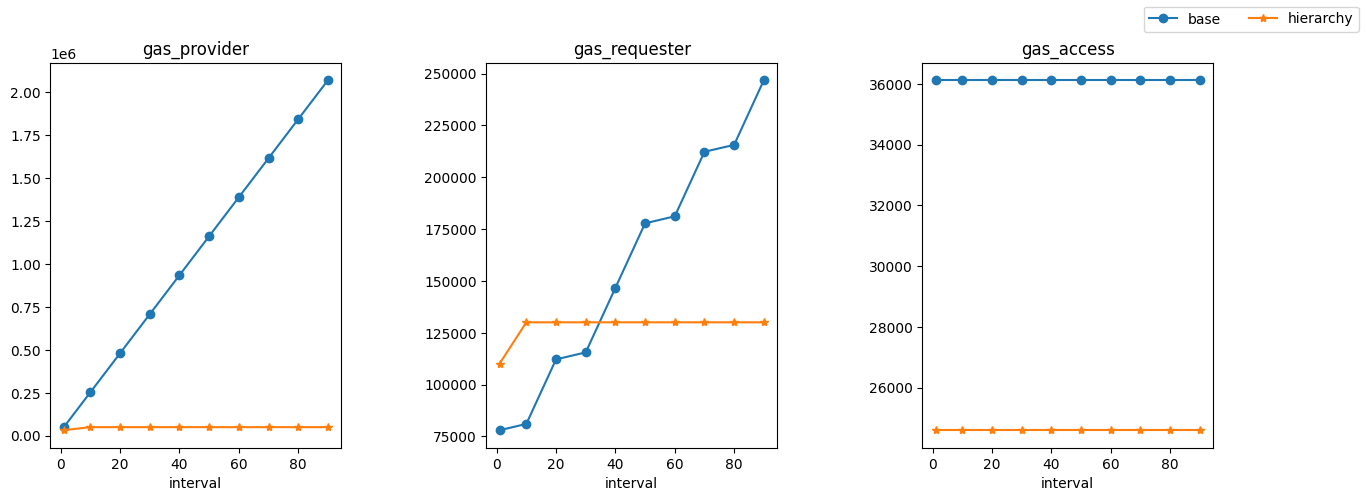

In [113]:
grouped_df = disease_data_frame.groupby("category")
line_style = {
    "base": "o-",
    "hierarchy": "*-",
}

import matplotlib.pyplot as plt

columns = ["gas_provider", "gas_requester", "gas_access"]
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))
locs = []
for i, column in enumerate(columns):
    ax = axes[i]
    ax.set_title(column)
    column_data = disease_data_frame[column]
    grouped_df = disease_data_frame.groupby("category")
    for group_name, group_data in grouped_df:
        loc = group_data.plot.line(
            ax=ax,
            x="interval",
            y=column,
            legend=True,
            style=line_style[group_name],
        )
        locs.append(loc)
        # ax.no_legend()
    # ax.legend(["base", "hierarchy"])
lines = []
labels = []

for ax in axes:
    Line, Label = ax.get_legend_handles_labels()
    ax.legend().remove()
    # print(Label)
    lines.extend(Line)
    labels.extend(Label)

plt.subplots_adjust(wspace=0.5)
fig.legend(lines[:2], ["base", "hierarchy"], loc="upper right", ncol=2)
plt.savefig("figs/disease.pdf")
plt.show()

## Area


In [114]:
countries = list(provider1.country_name_code_dict.keys())[:100]
provider1.country_names = countries
requester1.country_names = countries
provider1.group_names = ["EUROPEAN_UNION"]
requester1.group_names = ["EUROPEAN_UNION"]
provider1.estimate_gas = False
provider1.update_area_group_code()
provider1.estimate_gas = True
requester1.estimate_gas = True
gas_update_area_group_code = provider1.update_area_group_code()
gas_provider_simple = provider1.upload_area_code_simple()
gas_requester_simple = requester1.upload_area_code_simple()
gas_access_simple = requester1.access_area_simple(provider1)
data_base = []
data_base.append(
    {
        "interval": interval,
        "gas_provider": gas_provider_simple,
        "gas_requester": gas_requester_simple,
        "gas_access": gas_access_simple,
        "gas_update_area_group_code": gas_update_area_group_code,
    }
)
data_frame_base = pd.DataFrame(data_base)
print(data_frame_base.to_string(index=False))


provider1.estimate_gas = False
# provider1.update_area_group_code_baseline()
provider1.estimate_gas = True
requester1.estimate_gas = True
gas_update_area_group_code = provider1.update_area_group_code_baseline()
# gas_provider_simple = provider1.upload_area_code_baseline()
# gas_requester_simple = requester1.upload_area_code_baseline()
# gas_access_simple = requester1.access_area_baseline(provider1)
data_base = []
data_base.append(
    {
        "interval": interval,
        "gas_provider": gas_provider_simple,
        "gas_requester": gas_requester_simple,
        "gas_access": gas_access_simple,
        "gas_update_area_group_code": gas_update_area_group_code,
    }
)
data_frame_base = pd.DataFrame(data_base)
print(data_frame_base.to_string(index=False))

 interval  gas_provider  gas_requester  gas_access  gas_update_area_group_code
       90         68957          69109       35474                      121526
 interval  gas_provider  gas_requester  gas_access  gas_update_area_group_code
       90         68957          69109       35474                     6512959


In [126]:
provider1.estimate_gas = True
requester1.estimate_gas = True
data = []
data_simple = []
data_only = []

for interval in range(1,180,20):
    countries = list(provider1.country_name_code_dict.keys())[:interval]
    provider1.country_names = countries
    requester1.country_names = countries
    provider1.group_names = ["EUROPEAN_UNION"]
    requester1.group_names = ["EUROPEAN_UNION"]

    gas_provider = provider1.upload_area_code_baseline()
    gas_requester = requester1.upload_area_code_baseline()
    gas_access = requester1.access_area_baseline(provider1)
    data.append(
        {
            "interval": interval,
            "gas_provider": gas_provider,
            "gas_requester": gas_requester,
            "gas_access": gas_access,
            "category": "base",
        }
    )
    gas_provider_simple = provider1.upload_area_code_simple()
    gas_requester_simple = requester1.upload_area_code_simple()
    gas_access_simple = requester1.access_area_simple(provider1)

    data_simple.append(
        {
            "interval": interval,
            "gas_provider": gas_provider_simple,
            "gas_requester": gas_requester_simple,
            "gas_access": gas_access_simple,
            "category": "binary",
        }
    )

    # gas_provider_only = provider1.upload_area_code_only()
    # gas_requester_only = requester1.upload_area_code_only()
    # gas_access_only = requester1.request_access(provider1)

    # data_only.append(
    #     {
    #         "interval": interval,
    #         "gas_provider": gas_provider_only,
    #         "gas_requester": gas_requester_only,
    #         "gas_access": gas_access_only,
    #         "category": "binary",
    #     }
    # )


data_frame = pd.DataFrame(data)
data_frame_simple = pd.DataFrame(data_simple)
# data_frame_only = pd.DataFrame(data_only)
# print(data_frame.to_string(index=False))
# print(data_frame_simple.to_string(index=False))
# print(data_frame_only.to_string(index=False))


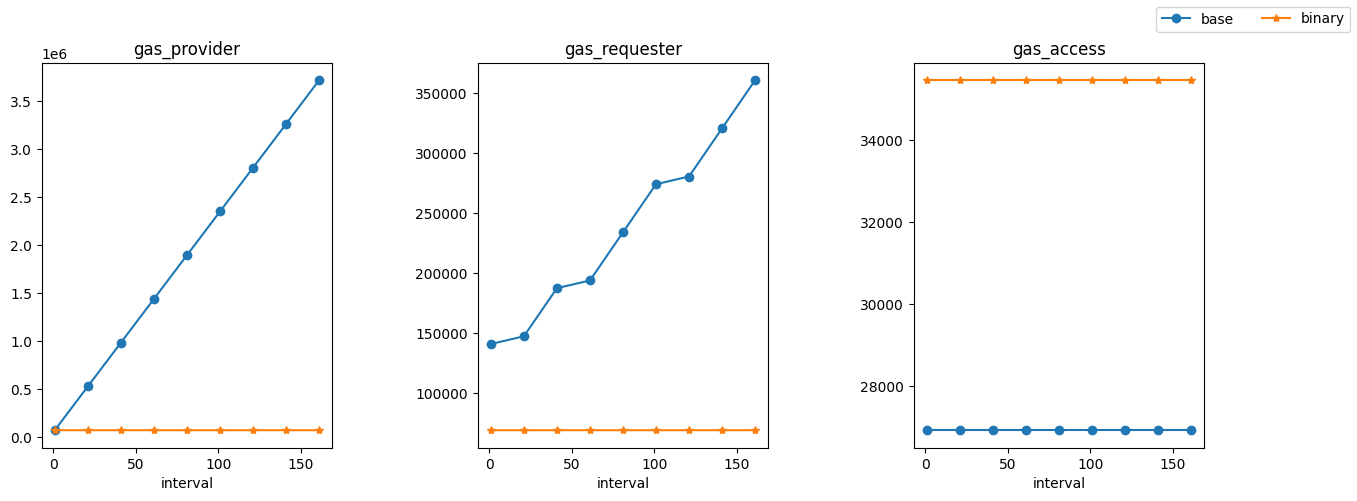

In [131]:
area_data = pd.concat([data_frame, data_frame_simple])
line_style = {
    "base": "o-",
    "binary": "*-",
}
columns = ["gas_provider", "gas_requester", "gas_access"]
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))
for i, column in enumerate(columns):
    ax = axes[i]
    ax.set_title(column)
    # ax.set_(200)
    # ax.set_xlim(0, 200)
    grouped_df = area_data.groupby("category")
    for group_name, group_data in grouped_df:
        # print(group_name)
        # print(group_data)

        group_data.plot.line(
            ax=ax,
            x="interval",
            y=column,
            legend=True,
            style=line_style[group_name],
        )
        # ax.no_legend()
    # ax.legend(["base", "hierarchy"])
lines = []
labels = []

for ax in axes:
    Line, Label = ax.get_legend_handles_labels()
    ax.legend().remove()
    # print(Label)
    lines.extend(Line)
    labels.extend(Label)

plt.subplots_adjust(wspace=0.5)
fig.legend(lines[:2], ["base", "binary"], loc="upper right", ncol=2)
plt.savefig("figs/area.pdf")
plt.show()

## Date

In [128]:
provider1.Start_Year = 2021
provider1.Start_Month = 1
provider1.Start_Day = 1
provider1.Months = 12
date_gas = provider1.upload_date()

requester1.Start_Year = 2021
requester1.Start_Month = 1
requester1.Start_Day = 1
requester1.Months = 12
date_gas = requester1.upload_date()


## Simple Items

In [129]:
provider_bools = BooleanItems()
provider_bools.ClinicalProfessionals = True
provider_bools.AcademicProfessionals = True
provider_bools.ReferenceOrControlMaterial = True

requester_bools = BooleanItems()
requester_bools.ClinicalProfessionals = True
requester_bools.AcademicProfessionals = True
requester_bools.ReferenceOrControlMaterial = True

provider1.boolItems = provider_bools
requester1.boolItems = requester_bools

provider1.estimate_gas = True
requester1.estimate_gas = True
provider_gas = provider1.upload_simple_items()
requester_gas = requester1.upload_simple_items()
access_gas = requester1.request_access(provider1)
print(
    f"upload_simple_items provider_gas {provider_gas}, requester_gas {requester_gas}, access_gas {access_gas}"
)

upload_simple_items provider_gas 46700, requester_gas 46852, access_gas 36118
